In [203]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [206]:
class TransducerLoss(torch.nn.Module):
    def __init__(self):
        super(TransducerLoss, self).__init__()
        
    def show_alignment(self, log_alpha):
        plt.imshow(log_alpha.cpu().data.numpy().transpose(), origin="lower"); plt.show()
    
    def compute_log_alpha_and_log_prob(self, encoder_out, decoder_out, y, blank):
        """
        encoder_out: FloatTensor (T, #labels)
        decoder_out: FloatTensor (U+1, #labels)
        y: LongTensor (U,)
        blank: int
        """
        T = len(encoder_out)
        U = len(y)
        
        log_alpha = torch.zeros(T, U+1) #[]
        for t in range(T):
            
            for u in range(U + 1):
                if u == 0:
                    
                    if t == 0:
                        log_alpha[t,u] = 0.
                    
                    else: #t > 0
                        null_t_1_0 = encoder_out[t-1, blank] + decoder_out[0, blank]
                        log_alpha[t,u] = log_alpha[t-1,u] + null_t_1_0
                        
                else: #u > 0
                    
                    if t == 0:
                        y_0_u_1 = encoder_out[t, y[u-1]] + decoder_out[u-1, y[u-1]]
                        log_alpha[t,u] = log_alpha[t,u-1] + y_0_u_1
                    
                    else: #t > 0
                        y_t_u_1 = encoder_out[t, y[u-1]] + decoder_out[u-1, y[u-1]]
                        null_t_1_u = encoder_out[t-1, blank] + decoder_out[u, blank]
                        
                        log_alpha[t,u] = torch.logsumexp(torch.stack([
                            log_alpha[t-1,u] + null_t_1_u,
                            log_alpha[t,u-1] + y_t_u_1 
                        ]), dim=0)
        
        null_T_1_U = encoder_out[T-1, blank] + decoder_out[U, blank]
        log_p_y_x = log_alpha[T-1,U] + null_T_1_U
        return log_alpha, log_p_y_x
    
    def forward(self,encoder_out,decoder_out,targets,input_lengths,target_lengths,reduction="none",blank=0):
        """
        encoder_out: FloatTensor (N, max(input_lengths), #labels)
        decoder_out: FloatTensor (N, max(target_lengths)+1, #labels)
        targets: LongTensor (N, max(target_lengths))
        input_lengths: LongTensor (N)
        target_lengths: LongTensor (N)
        reduction: "none", "avg"
        blank: int
        """
        batch_size = len(input_lengths)
        log_probs = []
        for i in range(0, batch_size):
            encoder_out_ = encoder_out[i, :input_lengths[i], :]
            decoder_out_ = decoder_out[i, :target_lengths[i]+1, :]
            y = targets[i, :target_lengths[i]]
            log_alpha, log_p_y_x = self.compute_log_alpha_and_log_prob(encoder_out_, decoder_out_, y, blank)
            self.show_alignment(log_alpha)
            log_probs.append(log_p_y_x)
        log_probs = torch.stack(log_probs)
        return log_probs
        

In [85]:
num_labels = 5
blank_index = num_labels-1 # last output = blank
batch_size = 1
pad = -1
T = torch.LongTensor([4])
U = torch.LongTensor([3])
y = torch.randint(low=0,high=num_labels-1,size=(U[0],)).unsqueeze(0).long()
print(y)

encoder_out = torch.randn(batch_size, max(T), num_labels).log_softmax(2).detach().requires_grad_()
decoder_out = torch.randn(batch_size, max(U)+1, num_labels).log_softmax(2).detach().requires_grad_()
print(encoder_out.shape)
print(decoder_out.shape)


tensor([[1, 1, 0]])
torch.Size([1, 4, 5])
torch.Size([1, 4, 5])


In [207]:
# use pre-trained CTC model
from models import CTCModel
from data import read_config
import sentencepiece as spm
import soundfile as sf

config = read_config("experiments/80_mel.cfg")
model = CTCModel(config=config).eval()
model.load_pretrained("experiments/80_mel/training/best_model.pth")
print(model)

tokenizer = spm.SentencePieceProcessor()
tokenizer.Load("tokenizer_1000_tokens.model")

x,fs = sf.read("../end-to-end-SLU/test.wav")
x = torch.tensor(x).unsqueeze(0).float()

guess = model.infer(x)[0]
truth = "HEY COMPUTER COULD YOU TURN THE LIGHTS ON IN THE KITCHEN PLEASE"
print(guess)
print(tokenizer.DecodeIds(guess))
print(tokenizer.EncodeAsIds(truth))
print(truth)

encoder_out = model.encoder.forward(x, T=None).detach().requires_grad_()
print(encoder_out.shape)
num_labels = encoder_out.shape[2]
blank_index = num_labels-1
T = torch.LongTensor([encoder_out.shape[1]])
U = torch.LongTensor([ len(tokenizer.EncodeAsIds(truth)) ]) #torch.LongTensor([ len(guess) ])#
y = torch.LongTensor([ tokenizer.EncodeAsIds(truth) ]) #torch.LongTensor([ guess ]) #
decoder_out = torch.ones(batch_size, max(U)+1, num_labels).log_softmax(2).detach().requires_grad_()
print(decoder_out.shape)
print(y)
print(U)

CTCModel(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): ComputeFBANK()
      (1): Conv(
        (conv): Conv1d(80, 512, kernel_size=(11,), stride=(2,))
      )
      (2): LeakyReLU(negative_slope=0.125)
      (3): GRU(512, 512, batch_first=True, bidirectional=True)
      (4): RNNOutputSelect()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=512, bias=True)
      (7): LeakyReLU(negative_slope=0.125)
      (8): Downsample()
      (9): GRU(512, 512, batch_first=True, bidirectional=True)
      (10): RNNOutputSelect()
      (11): Dropout(p=0.2, inplace=False)
      (12): Linear(in_features=1024, out_features=512, bias=True)
      (13): LeakyReLU(negative_slope=0.125)
      (14): GRU(512, 512, batch_first=True, bidirectional=True)
      (15): RNNOutputSelect()
      (16): Dropout(p=0.2, inplace=False)
      (17): Linear(in_features=1024, out_features=512, bias=True)
      (18): LeakyReLU(negative_slope=0.125)
      (19): Linear(in_featur

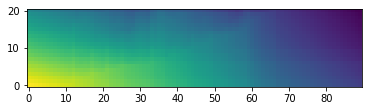

y: tensor([[ 26,  23, 464,  33,  86, 115,  38, 549,   5, 368,   3,  55,  20,   5,
         379,   7,  81,   8,  10, 779]])
loss: tensor(963.9097, grad_fn=<MeanBackward0>)
encoder_out:
tensor([[[-3.1079e+01, -3.1479e+01, -3.2192e+01,  ..., -2.7915e+01,
          -1.6461e+01, -3.9934e-05],
         [-3.5199e+01, -3.5653e+01, -3.5982e+01,  ..., -3.2546e+01,
          -2.0299e+01, -3.8147e-06],
         [-3.7666e+01, -3.8163e+01, -3.8327e+01,  ..., -3.5049e+01,
          -2.1831e+01, -1.4305e-06],
         ...,
         [-3.4317e+01, -3.4587e+01, -3.4978e+01,  ..., -3.1293e+01,
          -1.8083e+01, -5.7696e-05],
         [-2.9255e+01, -2.9440e+01, -2.9596e+01,  ..., -2.7685e+01,
          -1.5757e+01, -4.6111e-04],
         [-2.4411e+01, -2.4522e+01, -2.4562e+01,  ..., -2.3631e+01,
          -1.5108e+01, -2.9781e-03]]], requires_grad=True)
encoder grad:
tensor([[[-2.1835e-07, -1.7709e-10, -4.9841e-21,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-7.6187e-08, -1.7124e

In [211]:
transducer_loss = TransducerLoss()
log_probs = transducer_loss(encoder_out=encoder_out,decoder_out=decoder_out,targets=y,input_lengths=T,target_lengths=U,reduction="none",blank=blank_index)
loss = (-log_probs).mean()

print("y:", y)
print("loss:", loss)
loss.backward()

print("encoder_out:")
print(encoder_out)

print("encoder grad:")
print(encoder_out.grad[:,:,y[0]].shape)
print(encoder_out.grad[:,:,y[0]])
del encoder_out.grad

print("decoder_out:")
print(decoder_out)

print("decoder grad:")
print(decoder_out.grad)
del decoder_out.grad